# Lab 3 - Simulating Quantum Noise #
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$
---
## Overview
Noise is the enemy of useful quantum computing and the reason quantum error correction (QEC) is necessary in the first place. Noise from either the environment or the unavoidable imperfections of device controls produce errors that corrupt the quantum information stored on the qubits and ruin algorithm results. 

Though all QPUs share this reality, each QPU exhibits a unique noise profile depending on its qubit modality and a variety of other design factors. Understanding a device's noise is critical for guiding algorithm development, discovery of new QEC techniques, and improvements to the hardware itself. 


Simulating noisy QPUs can be extremely helpful for this task and complements the valuable but limited experimental data. For example, researchers can train QEC methods that rely on AI with massive simulated data sets. Similarly, insights from simulation can inform design improvements.  Simulation can also be used to model the physics of the individual qubits and identify specific sources of noise, much like NVIDIA uses GPUs to simulate digital twins for next generation GPUs in the design process.

This lab will provide an overview of simulating noisy quantum circuits. You will learn how to use CUDA-Q to perform a number of different simulations and apply the results to different uses cases.

**Prerequisites:**
Learners should have familiarity with Jupyter notebooks and programming in Python and CUDA-Q.  It is assumed the reader has some familiarity already with quantum computation and is comfortable with braket notation and the concepts of qubits, quantum circuits, measurement, and circuit sampling. The  CUDA-Q Academic course entitled "[Quick Start to Quantum Computing with CUDA-Q](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)" provides a walkthrough of this prerequisite knowledge if the reader is new to quantum computing and CUDA-Q or needs refreshing. Learners would also benefit from completing the first two notebooks in this series [The Basics of Classical and Quantum Error Correction](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/01_QEC_Intro.ipynb) and [Stabilizers, the Shor code, and the Steane code](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/02_QEC_Stabilizers.ipynb).

The list below outlines what you'll be doing in each section of this lab:

* **3.1** Define a quantum noise channel, the density matrix, and Kraus operators
* **3.2** Learn two ways to simulate noise: density matrix and trajectory simulation
* **3.3** Lean how to use noisy simulation for three different uses cases
    * **3.3a** Study the impact of noise on a standard quantum chemistry algorithm 
    * **3.3b** Use noise modeling to implement a noise mitigation technique
    * **3.3c** Run QEC experiments with noise models
* **3.4** Perform dynamical simulation of a qubit to build a noise model for quantum circuit simulation

Terminology and notation you'll use
* noise channel, density matrix, trajectory simulation, density matrix simulation, Kraus operator
* quantum error mitigation, zero noise extrapolation
* circuit-level noise experiments
* dynamical simulation, amplitude damping

Before we get started, excecute the cells below to load the necessary packages.

In [ ]:
### Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Uncomment the lines below and execute the cell to install cuda-q

#!pip install cudaq

#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mv cuda-q-academic-main/qec101/Images ./Images

In [ ]:
import cudaq
import numpy as np

## 3.1 Quantum Noise Channels ## 

In the first lab of this series, the concept of a **noise channel** was introduced. A noise channel is a mathematical model used to describe how a quantum state is impacted by the presence of noise. 

<img src="Images/noisy/nc.png" alt="Drawing" style="width: 800px;"/>

A noise channel can correspond to application of a gate to physical qubits, a qubit's interaction with another nearby qubit, or simply the passage of time and the resulting decay of the quantum state as it interacts with anything else from the environment. QEC is a promising solution to this problem as a logically encoded quantum state can go through the noise channel, impacting each data qubit, while providing a means for the original state to be restored.

<img src="Images/noisy/nc_qec.png" alt="Drawing" style="width: 1100px;"/>

However, as previous labs have emphasized, QEC is hard to implement, and the development of new QEC protocols is still an active research field.  In practice, experimental data obtained from the QPU can help measure quantities like gate fidelity and inform a **noise model** which captures all of the noise channels present in the device. This noise model can then be used to simulate data that emulates the performance of the QPU. 

There are many practical benefits to this that will be explored in this lab. A recent example of this is [NVIDIA's work with QuEra](https://developer.nvidia.com/blog/nvidia-and-quera-decode-quantum-errors-with-ai/) to build an AI decoder.  Training this model required a massive amount of data which could be obtained efficiently via simulation.  Noisy circuit simulation allowed for millions of syndromes to be obtained with their associated errors, something not possible to do with experimental data. 


### The Density Matrix ###

Before discussing some of the ways to simulate noise, it is necessary to take a step back and consider representation of a quantum state using the **density matrix**.  The density matrix ($\rho$) is a mathematical object that completely describes a quantum state and has the following properties. 

1. Its trace (sum of the diagonal elements) is equal to 1.
2. It is Hermitian: $\rho = \rho ^{\dagger}$
3. It is positive semi-definite. (All eigenvalues are positive.)

If a quantum system is in one of a any quantum states $\ket{\psi_i}$ with probability $p_i$, then the density matrix is defined as a linear combination of outer products of those states with probability coefficients:

$$\rho = \sum_i p_i \ket{\psi_i}\bra{\psi_i} $$


**Exercise 1:** use CUDA-Q's `get_state` function and the density matrix simulator (more on that later) to produce any three qubit density matrix.  Write code to check that the three properties listed above are met. Make sure to set tolerances on these checks so that, for example, an eigenvalue of zero is not wrongfully flagged as `-1.2e-20`. 


In [ ]:
import cudaq
import numpy as np

cudaq.set_target("density-matrix-cpu")

#Build Kernel and get state
#TODO 

#get density matrix
#TODO

# Compute Trace
#TODO

# Check if Hermitian
#TODO

# Check if positive semi-definite
#TODO



<br>
<br>

Statevectors correspond to **pure states**, while the density matrix can describe **mixed states**, that is an overall state composed of a combination of pure states.

A state is considered pure if the trace of $\rho^2$ is equal to 1.

This can be a bit confusing because a pure state can actually be a superposition state and a mixed state can be a combination of two states that do not describe superpositions.  The following exercise will make this more clear.

**Exercise 2:**

Consider the density matrix $\rho = \frac{1}{2}\ket{00}\bra{00} + \frac{1}{2}\ket{11}\bra{11}$.  

Using CUDA-Q build kernels for the $\ket{00}$ state and the $\ket{11}$ state, using these kernels and the `get_state` command define the density matrix $\rho$, and compute trace($\rho^2$).  Is the state pure?

In [ ]:
#TODO


Now, code a Bell state and do the same thing with its density matrix.  Is it a pure state?

In [ ]:
#TODO


<br>
<br>

A mixed state means that there is classical uncertainly about which quantum state defines the system, even if both quantum states are deterministic like $\ket{00}$ and $\ket{11}$.   However, a bell state is pure, meaning that the overall quantum state is known with certainly, even if the state describes a superposition with inherent uncertainty.  Another key term is **completely mixed state**, which refers to a density matrix where all of the eigenvalues are the same, meaning the density matrix describes the state with the theoretical maximum of uncertainty. 

### Kraus Operators ###

Now, why the business about density matrices?  The answer is that a noise channel needs to  be an effective model that can generalize to impact mixed states. In fact, many noise channels will produce a mixed state from a pure state.

Mathematically this is done with **Kraus operators** ($K_i$) that evolve the density matrix as the state proceeds through a noisy channel $\epsilon$.

$$ \epsilon(\rho) = \sum_i K_i\rho K_i^{\dagger} $$

Kraus operators have the condition that $ \sum_i K_i K_i^{\dagger} =1 $ so the trace of the density matrix is preserved.

For example, a valid set of operators is $K_0 = \sqrt{1-p} I $ and $K_1 = \sqrt{p}X$ which will perform a bitflip error with probability $p$ and apply the identity (no change) with probability $1-p$. Let's apply this to the density matrix, $\rho_0$, for the $\ket{0}$ state. The result becomes $ \epsilon(\rho_0) = (1-p)I\rho_0 I + pX\rho_0 X $. Notice the result is now mixed state. 

The table below summarizes some of the channels included in CUDA-Q which you will use in later exercises.  Notice too, that each noise channel can be geometrically represented as a deformation of the Bloch sphere.


<img src="Images/noisy/channels.png" alt="Drawing" style="width: 800px;"/>

 

By applying any number of Kraus operators to the density matrix, it is possible to evolve it and sample the resulting state to determine how noise impacts the output. This is easily accomplished in CUDA-Q with the `density-matrix-cpu` backend.  You can then build a noise model consisting of noisy channels applied to specific gate operations with select probabilities. The exercise below will get you started with the syntax.

**Exercise 3:** 

You will be using CUDA-Q's built in noise channel tools throughout this lab.  Get a sense for how it works by building a two qubit kernel and perform an $X$ operation on each qubit.  Edit the code block below to build a noise model consisting of two bitflip channels with probabilities of .10 and .25 on the $X$ gate for qubit 0 and 1, respectively.  Does the sample distribution agree with what you would expect? 


In [ ]:
noise = cudaq.NoiseModel() # #Defines an empty noise model

noise.add_channel('x', [0], cudaq.BitFlipChannel(.1)) # Adds a bitflip error channel (p=0.1) to X gates on qubit 0.
#TODO Add noise channel for second qubit

@cudaq.kernel
def test():
    reg = cudaq.qvector(2)
    x(reg)


print(cudaq.sample(test, noise_model=noise))

## 3.2 Two Ways to Simulate Noise ##

Density matrix simulation can produce exact results with the quality of simulation limited only by the accuracy of the underlying noise model.  Unfortunately, density matrix simulation is expensive and requires storage of the entire $2^N \times 2^N $ matrix, limiting it to a smaller number of qubits. 

This scalability problem can be circumvented with a method called trajectory based simulation which allows for approximate noise simulation at much larger scales.  Unlike density matrix simulation that applies Kraus operators to every state, trajectory based simulation assumes the Kraus operators occur as a Markov process. 

The assumption of a Markov process is that the application of each Kraus operator is independent from the others. This is usually a reasonable assumption as a physical QPU might, for example, only apply gates in an isolated gate zone. 

The code blocks below will make it clear how the two approaches differ. Consider a very basic circuit that prepares the $\ket{111}$ state with bitflip errors on each qubit corrupting the result. First, run the cell below.  Notice that `get_state` returns the same density matrix each time you run the code.  This density matrix describes the mixture of all possible pure states and returns the sample distribution below.

In [5]:
import cudaq

cudaq.set_target("density-matrix-cpu")

noise = cudaq.NoiseModel()
for q in range(3):
    noise.add_channel('x', [q], cudaq.BitFlipChannel(.2))

@cudaq.kernel
def test():
    reg = cudaq.qvector(3)
    x(reg)


cudaq.set_noise(noise)
for x in range(2):
    print(cudaq.get_state(test))


print(cudaq.sample(test, noise_model = noise))

(0.008,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)
    (0,0) (0.032,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)
    (0,0)     (0,0) (0.032,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)
    (0,0)     (0,0)     (0,0) (0.128,0)     (0,0)     (0,0)     (0,0)     (0,0)
    (0,0)     (0,0)     (0,0)     (0,0) (0.032,0)     (0,0)     (0,0)     (0,0)
    (0,0)     (0,0)     (0,0)     (0,0)     (0,0) (0.128,0)     (0,0)     (0,0)
    (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0) (0.128,0)     (0,0)
    (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0) (0.512,0)

(0.008,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)
    (0,0) (0.032,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)
    (0,0)     (0,0) (0.032,0)     (0,0)     (0,0)     (0,0)     (0,0)     (0,0)
    (0,0)     (0,0)     (0,0) (0.128,0)     (0,0)     (0,0)     (0,0)     (0,0)
    (0,0)     (0,0)     (0,0)     (0,0)

Trajectory based simulation can run in CUDA-Q by simply changing the target to `nvidia`.  If the kernel below had no noise, the statevector (output from `get_state`) should be [0,0,0,0,0,0,0,1] corresponding to the $\ket{111}$ state. When sampling is performed with the trajectory based simulator, the Kraus operators are applied based on their probabilities to produce a new state vector for each shot. The widget below allows you to explore the possible outcomes and their associated probabilities.   

Try running the CUDA-Q simulation above with two or three different bitflip error probabilities and set the slider below to match. Confirm that the results from the density matrix simulations above match the expected distribution from the trajectory-based approach. You will need to move the `Images > noisy > trajectory_widget.py` file from the [CUDA-Q Academic github repository](https://github.com/NVIDIA/cuda-q-academic) into your working directory to execute this optional cell.

In [ ]:
from Images.noisy.trajectory_widget import show_error_tree_widget

# this will render the entire widget
show_error_tree_widget()

Running the code below, notice `get_state` produces a different state vector each time. Because the number of possible trajectories is small, trajectory based sampling can reproduce the same distribution that would be obtained from density matrix simulation.

⚠️

Just a heads-up: The rest of this notebook is designed to be run on an environment with a GPU. If you don't have access to a GPU, feel free to read through the cells and explore the content without executing them. Enjoy learning!

⚠️

In [7]:
import cudaq

cudaq.set_target("nvidia")

noise = cudaq.NoiseModel()
for q in range(3):
    noise.add_channel('x', [q], cudaq.BitFlipChannel(.2))

@cudaq.kernel
def test():
    reg = cudaq.qvector(3)
    x(reg)

cudaq.set_noise(noise)
for x in range(20):
    print(cudaq.get_state(test))

print(cudaq.sample(test))

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (1,0), (0,0), (0,0), (0,0), (0,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]

SV: [(0,0), (0,0), (0,0), (0,0), (1,0), (0,0), (0,0), (0,0)]

SV: [(0,

Another benefit of trajectory based simulation is that it can be used with tensor network based simulators to simulate circuits that would be far too large for density matrix or statevector simulation. CUDA-Q can run exact tensor network or approximate Matrix Product State (MPS) simulations with trajectory based simulation to simulate systems of hundreds to thousands of qubits.

Clever sampling algorithms can also be used to filter trajectories and exclude certain types of errors or focus on sampling only a subset of the most likely errors.  A [recent paper published by NVIDIA research]()https://arxiv.org/pdf/2504.16297 explains this in greater detail and described how methods like this can sample trillions of noisy samples in just a few hours using an AI supercomputer. This is extremely helpful for training AI QEC decoders where experimental data cannot be obtained in sufficient volume.

 ## 3.3 Use cases for Noisy Simulations ##

This section will explore three use cases of noisy simulation used to model the impact of noise patterns on algorithms, perform quantum error mitigation, and run QEC experiments.

### 3.3a: Understanding How Noise Impacts Algorithm Results ##3

A natural application of noisy simulation is to explore how different noise patterns might impact the results of an algorithm.  Such simulations can be beneficial for a number of reasons. This section along with the following two will explore three use cases for noisy circuit simulation. 

The first use case is to better understand how device noise impacts the outcome of an algorithm. Researchers can use these sorts of results to produce insights that guide compilation methods by identifying how particular algorithms might be more or less sensitive to particular noise channels. Such an approach is also useful to develop noise models by tuning them to agree with the results obtained running the same application experimentally.

This section will walk you through an exercise to explore the impact of noise on a standard chemistry experiment.  The CUDA-Q Solvers library makes it easy to prepare a quantum circuit to compute the ground state energy of a molecule. The code section below prepares a circuit with the standard UCCSD ansatz as well as the Hamiltonian of the hydrogen molecule. Run the cell below to get the noiseless energy and see a print out of the circuit.  Note: the circuit parameters are not optimized, but this does not matter as it is just a reference point to study the impact of noise. 

In [ ]:
# If you are working in an environment that does not have cudaqx installed, 
# uncomment the code below to install cudaq-solvers and the required dependencies.  
# Then restart the kernel before executing the next cell.
#!sudo apt-get update && sudo apt-get install -y gfortran
#!pip install cudaq-solvers -q
#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mkdir Images
#!mv cuda-q-academic-main/qec101/Images/noisy ./Images/noisy

In [ ]:
# install `qutip` and `ipywidgets` in the current Python kernel. Skip this if they are already installed.
# `matplotlib` is required for all visualization tasks.
# Make sure to restart your kernel if you execute this!
# In a Jupyter notebook, go to the menu bar > Kernel > Restart Kernel.
# In VSCode, click on the Restart button in the Jupyter toolbar.

# The '\' before the '>' operator is so that the shell does not misunderstand
# the '>' qualifier for the bash pipe operation.

import sys

try:
    import matplotlib.pyplot as plt
    import qutip
    import ipywidgets as widgets

except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install qutip\>=5 matplotlib\>=3.5
    !{sys.executable} -m pip install ipywidgets
    print("\nNew libraries have been installed. Please restart your kernel!")

In [ ]:

import cudaq, cudaq_solvers as solvers
from typing import List, Optional
cudaq.set_target("nvidia")
print(cudaq.sample(test, noise_model = noise))


geometry = [('H', (0., 0., 0.)), ('H', (0., 0., .7474))]
molecule = solvers.create_molecule(geometry, 'sto-3g', 0, 0)

noise_empty = cudaq.NoiseModel()

numQubits = molecule.n_orbitals * 2
numElectrons = molecule.n_electrons
spin = 0
initialX = [-.2] * solvers.stateprep.get_num_uccsd_parameters(
    numElectrons, numQubits)

@cudaq.kernel
def uccsd():
    q = cudaq.qvector(numQubits)
    for i in range(numElectrons):
        x(q[i])
    solvers.stateprep.uccsd(q, initialX, numElectrons, spin)

#noiseless value
print(cudaq.observe(uccsd, molecule.hamiltonian, noise_model = noise_empty).expectation())
noiseless = cudaq.observe(uccsd, molecule.hamiltonian, noise_model = noise_empty).expectation()

print(cudaq.draw(uccsd))

Note: you may need to restart the kernel to use updated packages.
{ 000:9 001:39 010:33 011:128 100:39 101:132 110:130 111:490 }

-1.0404318468267384
     ╭───╮╭───────────╮                                ╭────────────╮╭───╮»
q0 : ┤ x ├┤ rx(1.571) ├──●──────────────────────────●──┤ rx(-1.571) ├┤ h ├»
     ├───┤╰───────────╯╭─┴─╮                      ╭─┴─╮╰────────────╯╰───╯»
q1 : ┤ x ├─────────────┤ x ├──●────────────────●──┤ x ├───────────────────»
     ├───┤             ╰───╯╭─┴─╮╭──────────╮╭─┴─╮├───┤╭───────────╮      »
q2 : ┤ h ├──────────────────┤ x ├┤ rz(-0.1) ├┤ x ├┤ h ├┤ rx(1.571) ├──────»
     ├───┤                  ╰───╯╰──────────╯╰───╯╰───╯╰───────────╯      »
q3 : ┤ h ├────────────────────────────────────────────────────────────────»
     ╰───╯                                                                »

################################################################################

                                            ╭───╮    ╭───╮                 »
──●───

**Exercise 4:**

Now, write a function that computes the expectation values for various configurations of errors.  The function comments will guide you on the inputs and what the function should return.

In [ ]:
def get_noisy_data(e_type =[], gate=[] , qubit=[], prob=[], shots=-1, trajectories=None):
    """The function takes in various configurations of noise channels, builds a noise model, uses the noise model to obtain 40 expectation values,
       and the returns a list of the difference between the noisy expectation values and the noiseless.

    Parameters
    ----------
    e_type: list[int]
        List designating the type of each error applied for a given noise channel.
            1=phaseflip
            2=amplitude damping
            3=depolarization
    gate: list[str]
        List designating the type of gate each error is applied on (e.g. 'h' or'x').
    qubit: list[int]
        List designating the qubit index where the noise channel is applied.
    prob: list[float]
        List designates the probability of error for each noise channel
    shots: int
        Designates the number of shots used to compute the expectation value.  Default (-1) is exact, non-shot based result.
    trajectories: int
        Designates the number of trajecttores sampled when computing the expectation value.

    Returns
    -------
    list[float]
        List of length 40 where each elementis the diffence between the noisy and noiseless value.
    """

    #TODO

The function below, will take the result from `get_noisy_data` and plot them.  Just enter each output from `get_noisy_data` as an element of the `datasets` list variable, name the categories for the x-axis, and label the datasets if more than one is provided. The next cell provides an example.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(datasets, categories, labels=None):
    """
    Plots the mean and ±1 SD error bars for one or more datasets,
    with the y-axis centered at 0 for each category.
    
    Parameters:
    -----------
    datasets : list of lists (single dataset) or list of list of lists (multiple datasets)
        Each sub-list (or sub-sub-list if multiple) contains numeric values for a given category.
    categories : list of str
        Labels for the categories corresponding to each data sub-list.
    labels : list of str, optional
        Labels for each dataset if multiple datasets are provided.
    """
    # If only a single dataset (list of lists) is given, wrap it so we can loop uniformly
    if not isinstance(datasets[0][0], (list, np.ndarray)):
        datasets = [datasets]
    
    # If no labels given, auto-generate labels
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(datasets))]

    plt.figure()
    all_vals = []  # Collect all mean±std values to compute symmetric y-axis

    # Plot each dataset with a small horizontal offset
    for i, data in enumerate(datasets):
        means = [np.mean(vals) for vals in data]
        stds = [np.std(vals) for vals in data]
        x_positions = np.arange(len(categories)) + i * 0.1

        plt.errorbar(
            x_positions, means, yerr=stds, fmt='o', capsize=5, 
            label=labels[i]
        )

        # Store values for y-axis range calculation
        all_vals.extend([m + s for m, s in zip(means, stds)])
        all_vals.extend([m - s for m, s in zip(means, stds)])

    # Center x-ticks between all plotted points
    midpoint_offset = ((len(datasets) - 1) * 0.1) / 2
    plt.xticks(np.arange(len(categories)) + midpoint_offset, categories)
    
    plt.ylabel('Mean Value (Expectation Value)')
    plt.title('Mean ±1 SD Error Bars (Centered at 0 = No Noise)')

    # Compute symmetric y-limits around 0
    y_upper = max(all_vals)
    y_lower = min(all_vals)
    max_range = max(abs(y_upper), abs(y_lower))
    plt.ylim([-max_range, max_range])

    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Reference line at y=0

    if len(datasets) > 1:
        plt.legend()

    plt.show()


#### Analyzing Shot Number ####

A source of noise not discussed thus far, and of a completely different nature than any physical noise channel, is sampling error. Sampling based quantum algorithms can produce inaccurate results simply due to sampling error, even if the hardware were perfect.  The code below, demonstrates how to use the `plot_data` function, and produces the distributions of hydrogen ground state energies obtained with anywhere from 10 to 10000 shots compared to 0 which is the noiseless result in the limit of infinite samples.

Notice how sampling based error is centered on the noiseless result and rapidly dissipates as more shots are used.   The rest of the simulations below will not perform shot based sampling so the only deviations from zero are due to the noise channels you implement below. Nevertheless, it is important to not forget that sampling error is a ubiquitous source of error for most quantum algorithms.

In [ ]:
data = [get_noisy_data(shots=10),
        get_noisy_data(shots=100),
        get_noisy_data(shots=1000),
        get_noisy_data(shots=10000),
]

categories = ['10','100', '1000', '10000' ] 
labels =['series 1']

plot_data([data], categories, labels)



#### Analyzing Trajectory Number ####

Similar to sampling error, trajectory based noise simulation is also dependent on the number of trajectories used to compute the expectation value. Even if each trajectory is used to compute the expectation value exactly, if too few statevectors are sampled, the results of the noisy simulations can become unreliable. 

Build a data set that only applies bitflip errors on $X$ gates for every qubit with probability 0.01. Vary the trajectories from 10 to 10000 and comment on the results.  

Does this noise model systematically over or under estimate the energy prediction? Could you be confident in this observation if you only used 10 trajectories?

In [ ]:
#TODO

#### Analyzing Error Probability and Gate Type ####

Now, turning to questions more specific to the structure of this algorithm's circuit, one can ask how changing the probability of a bitflip error impacts the computed energy. Plot the results corresponding to bitflip errors on all $X$ gates for all qubits with decreasing probabilities of .1, .01, .001, .0001. Plot a second series on the same graph but this time have the bitflip error applied on the $H$ gates.


For which type of gate are bitflip errors more problematic to the result?

In [ ]:
#TODO

#### Analyzing Error Type ####

Now, fix the error probability at 0.1 and this time vary the type of error.  Keep the two series with errors occurring on $X$ and $H$ gates.

Which type of error is most severe? Are there any errors that have little to no impact?

In [ ]:
#TODO

#### Analyzing Error Location (Qubit) ####

Finally, keep the two series and now perform only Amplitude Damping errors. This time, set all of the probabilities equal to 0, expect for the single error prone qubit which is set to a probability of 0.1.  

If you had a QPU where you knew qubit A was particularly prone to amplitude damping for some reason, when you compile the algorithm, which wire of the quantum circuit (q0, q1, q2, q3) should map to qubit A to ensure the best results based on your simulations?

In [ ]:
#TODO

### 3.3b: Zero Noise Extrapolation ###

QPU results today are sometimes improved using **quantum error mitigation (QEM)** techniques.  QEM techniques use classical postprocessing to improve results without the utilization of proper QEC protocols. One such QEM technique is **zero noise extrapolation (ZNE)**.  The idea behind ZNE is that it is really hard to remove noise from an algorithm run on a physical QPU, but it is very easy to add noise. 

The ZNE process works by applying increasing factors of error through clever application of the identity operator. For example, consider a circuit composed of a single layer of $R_X$ rotations of $\pi$ radians. Applying the same gate three times is mathematically the same as applying it once and should have no impact on the result. 

$$R_X(\pi)R_X(\pi)R_X(\pi) = R_X(\pi)I = R_X(\pi)$$

Experimentally, this is truly the identity operation as each gate is a noise channel and the total noise factor is increased from 1x to 3x.  If this procedure is continued (5x, 7x, 9x, ...) the data can be fit to a curve and extrapolated back to estimate the experimentally inaccessible case of a 0x noise factor!  So, paradoxically, adding noise can improve the result. 

<img src="Images/noisy/zneplot.png" alt="Drawing" style="width: 1000px;"/>


ZNE is a useful technique because it can be used experimentally. Noisy circuit simulation can demonstrate its effectiveness and help benchmark the effectiveness of ZNE when used on a physical QPU, help refine noise models, and test other QEM techniques before running experiments.  

**Exercise 5:**

You will now code an ZNE example by following the steps below:

1. Create a Random Hamiltonian for a larger (20 qubit circuit)
2. Define a quantum circuit with a layer of $R_x(\pi/2)$ gates followed by a layer of $X$ gates.
3. Put a bitflip error on the $X$ gates and an Amplitudes Damping error on the $R_X$ gates.
4. Perform ZNE to obtain a correction for each. (Hint: use the `np.poly1d()` to fit a polynomial.)
5. Apply the correction to the original noisy circuit and calculate the percent error of the noisy circuit and the ZNE corrected result relative to the noiseless case.

In [ ]:
#Make Hamiltonian
#TODO

#Simulate noise and fit extrapolations
#TODO


def plot_zero_noise_extrapolation(noise_factors, measurements, poly_fit):
    """
    Plot the original data vs. noise factor and the polynomial fit extended 
    down to noise=0 to show the extrapolation result.
    """
    # Create a range of noise values from 0 to slightly beyond the largest noise factor
    x_range = np.linspace(0, max(noise_factors) + 0.5, 50)
    y_fit = poly_fit(x_range)

    # Plot measured data points
    plt.scatter(noise_factors, measurements, label='Measured Data', color='blue')
    # Plot polynomial fit
    plt.plot(x_range, y_fit, label='Fit (degree = {})'.format(poly_fit.order), color='red')

    # Highlight the zero-noise extrapolation point
    extrapolated_value = poly_fit(0)
    plt.scatter([0], [extrapolated_value], color='green', zorder=5, 
                label='Zero-Noise Extrapolation = {:.3f}'.format(extrapolated_value))
    
    plt.xlabel('Noise Factor')
    plt.ylabel('Measured Expectation Value')
    plt.title('Zero-Noise Extrapolation')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Percent Error of ZNE Estimate {(extrapolated_value - noiseless)/noiseless*100} %")


print(f"Percent Error of Uncorrected Noisy Circuit: {(results[0] - noiseless)/noiseless*100} %")


plot_zero_noise_extrapolation(factors, results, linear)
plot_zero_noise_extrapolation(factors, results, quadratic)


### 3.3c: QEC Experiments ###



Noisy circuit simulation is perhaps most useful as a tools for QEC researchers.  One can test how a code will perform in a variety of different noise conditions.  Assuming an accurate noise model, this can be a great way to assess characteristics of new codes. Below you will add noise to the Steane code you prepared in lab 2. 

**Exercise 6:**

Apply noise to the Steane code in the following three ways and determine which case produces the best and worst logical error rates, keeping the probability of error fixed at 0.05.  In which cases is the logical error rate an improvement over the 0.05 error rate?
1. Use `cudaq.apply_noise(cudaq.XError, p, data_qubits[j])` to manually apply Kraus operators following encoding of the Steane code but before the stabilizer checks are run.  These errors are not tied to gates but model errors induced while the system idles.
2. Now, use `cudaq.apply_noise(cudaq.Depolarization2, p, data_qubits[i], data_qubits[j])` to apply a depolarization error following all of the two qubit gates in the encoding circuit, whee q and r are the two qubits involved in the gate operation.
3. Apply a bitflip noise channel to all `mz` measurements.  In this case, errors are also possible in measurements performed on the ancillas.  This helps model situations where measurements are performed in a way that is not fault tolerant.

In [ ]:
import cudaq

cudaq.set_target('stim')

p = 0.05
cudaq.unset_noise()
noise = cudaq.NoiseModel()

@cudaq.kernel
def steane_code():
    """Prepares a kernel for the Steane Code
    Returns
    -------
    cudaq.kernel
        Kernel for running the Steane code
    """   
    data_qubits = cudaq.qvector(7)
    ancilla_qubits = cudaq.qvector(3)

    # Create a superposition over all possible combinations of parity check bits
    h(data_qubits[4])
    h(data_qubits[5])
    h(data_qubits[6])

    #Entangle states to enforce constraints of parity check matrix

    x.ctrl(data_qubits[0],data_qubits[1])
    x.ctrl(data_qubits[0],data_qubits[2])
    x.ctrl(data_qubits[4],data_qubits[0])
    x.ctrl(data_qubits[4],data_qubits[1])
    x.ctrl(data_qubits[4],data_qubits[3])

    x.ctrl(data_qubits[5],data_qubits[0])
    x.ctrl(data_qubits[5],data_qubits[2])
    x.ctrl(data_qubits[5],data_qubits[3])

    x.ctrl(data_qubits[6],data_qubits[1])
    x.ctrl(data_qubits[6],data_qubits[2])
    x.ctrl(data_qubits[6],data_qubits[3])

    # Detect Z errors
    h(ancilla_qubits)

    x.ctrl(ancilla_qubits[0],data_qubits[0])
    x.ctrl(ancilla_qubits[0],data_qubits[1])
    x.ctrl(ancilla_qubits[0],data_qubits[3])
    x.ctrl(ancilla_qubits[0],data_qubits[4])

    x.ctrl(ancilla_qubits[1],data_qubits[0])
    x.ctrl(ancilla_qubits[1],data_qubits[2])
    x.ctrl(ancilla_qubits[1],data_qubits[3])
    x.ctrl(ancilla_qubits[1],data_qubits[5])

    x.ctrl(ancilla_qubits[2],data_qubits[1])
    x.ctrl(ancilla_qubits[2],data_qubits[2])
    x.ctrl(ancilla_qubits[2],data_qubits[3])
    x.ctrl(ancilla_qubits[2],data_qubits[6])

    h(ancilla_qubits)

    sz1 = mz(ancilla_qubits[0])
    sz2 = mz(ancilla_qubits[1])
    sz3 = mz(ancilla_qubits[2])

    #Reset ancillas
    reset(ancilla_qubits)

    # Detect X errors
    h(ancilla_qubits)

    z.ctrl(ancilla_qubits[0],data_qubits[0])
    z.ctrl(ancilla_qubits[0],data_qubits[1])
    z.ctrl(ancilla_qubits[0],data_qubits[3])
    z.ctrl(ancilla_qubits[0],data_qubits[4])

    z.ctrl(ancilla_qubits[1],data_qubits[0])
    z.ctrl(ancilla_qubits[1],data_qubits[2])
    z.ctrl(ancilla_qubits[1],data_qubits[3])
    z.ctrl(ancilla_qubits[1],data_qubits[5])

    z.ctrl(ancilla_qubits[2],data_qubits[1])
    z.ctrl(ancilla_qubits[2],data_qubits[2])
    z.ctrl(ancilla_qubits[2],data_qubits[3])
    z.ctrl(ancilla_qubits[2],data_qubits[6])

    h(ancilla_qubits)

    sx1 = mz(ancilla_qubits[0])
    sx2 = mz(ancilla_qubits[1])
    sx3 = mz(ancilla_qubits[2])


    # Correct X errors

    if sx1 and sx2 and sx3:
        x(data_qubits[3])
    elif sx1 and sx2:
        x(data_qubits[0])
    elif sx1 and sx3:
        x(data_qubits[1])
    elif sx2 and sx3:
        x(data_qubits[2])
    elif sx1:
        x(data_qubits[4])
    elif sx2:
        x(data_qubits[5])
    elif sx3:
        x(data_qubits[6])



    # Correct Z errors

    if sz1 and sz2 and sz3:
        z(data_qubits[3])
    elif sz1 and sz2:
        z(data_qubits[0])
    elif sz1 and sz3:
        z(data_qubits[1])
    elif sz2 and sz3:
        z(data_qubits[2])
    elif sz1:
        z(data_qubits[4])
    elif sz2:
        z(data_qubits[5])
    elif sz3:
        z(data_qubits[6])

    mz(data_qubits)



results = cudaq.sample(steane_code, shots_count=10000, noise_model=noise)

print(results)

ones = 0
zeros = 0 
for bitstring in results:
    counts = results.count(bitstring)
    parity = sum(int(bit) for bit in bitstring) % 2
    
    if parity == 0:
        zeros += 1*counts
    else:
        ones += 1*counts

logical_rate = ones/(zeros+ones)
            
print(f"logical error rate:{logical_rate}")


## 3.4: Using Dynamical Simulations to Build a Noise Model ###

The noise models used thus far are meant to mimic the underlying physics of physical qubits. Often, noise models are heavily informed by experiment, but extracting meaningful insights can be extremely difficult for such complex systems. 

<img src="Images/noisy/dynamics_noise_model.png" alt="Drawing" style="width: 1200px;"/>

To help with this task, the physics of the qubits can also be simulated to better understand noise sources and improve interpretation of experimental data.  This sort of simulation is known as dynamical simulation and models the evolution of a quantum system over time as the system interacts with its environment. 

Exercise:

The code below will help you walk through an example of using dynamical simulation to produce a noise model for a single qubit amplitude damping channel. Recall, the corresponding noise channel looks like this. 

$$ \epsilon(\rho)  = \sqrt{1-p}*\rho + \sqrt{p}*\rho*0.5*(X+iY) $$

Thus, the goal is to simulate a simple qubit system to determine what $p$, the probability of energy loss resulting in decay to the ground state, is.

Dynamical simulation is its own topic that warrants a detailed introduction that will not be provided here.  Instead, the steps of the dynamical simulation will be discussed at a high level while curious readers can explore the CUDA-Q dynamics page for more information and more detailed examples.

To get started, import the following functions and libraries. This example will use the CUDA-Q dynamics backend, set like any other backend. 

In [18]:
import cudaq
from cudaq import spin, operators, ScalarOperator, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt
cudaq.set_target("dynamics")

You will simulate a superconducting transmon qubit which is driven close to resonance, to produce so called Rabi oscillations. You will model a qubit which has a set resonant frequency, add a driving term that depends on time and will drive the system close to its resonant frequency, and by doing so, introduce a change in population from the $\ket{0}$ state to the  $\ket{1}$ state.  In other words, you will simulate thr underlying physics required to perform an $X$ gate.

The first step is to construct the Hamiltonian of the system. The Hamiltonian consists of a $Z$ term that encodes the resonant frequency for the qubit corresponding to the transition from the $\ket{0}$ to the $\ket{1}$ state. The second, is a driving term that applies a time dependent function  towards the qubits resonant frequency.  When this happens, Rabi oscillations occur and the population of the system changes from 100\% $\ket{0}$ to 100\% $\ket{1}$, that is, an $X$ gate applied to the qubit!


**Exercise 7:**

The code below sets up the the problem Hamiltonian, defines the dimensions of the system and specifies the initial ground state. The terms have more meaning than described above, but their details are not relevant for the purposes of this exercise.

In [19]:
omega_z = 10.0 * 2 * np.pi
omega_x = 2 * np.pi
omega_drive = 1 * omega_z

hamiltonian = 0.5 * omega_z * spin.z(0)
hamiltonian += omega_x * ScalarOperator(lambda t: np.cos(omega_drive * t)) * spin.x(0)

dimensions = {0: 2}

rho0 = cudaq.State.from_data(
    cp.array([[1.0, 0.0], [0.0, 0.0]], dtype=cp.complex128))

Dynamics simulations are performed numerically and require a time step specifying how the evolution operator is applied. For this problem it is setup below. 

In [20]:
t_final = np.pi / omega_x
dt = 2.0 * np.pi / omega_drive / 100
n_steps = int(np.ceil(t_final / dt)) + 1
steps = np.linspace(0, t_final, n_steps)
schedule = Schedule(steps, ["t"])

You are now ready to run the simulation using CUDA-Q's `evolve` function, which does require GPU access. The code cell below shows the baseline case where the qubit does not interact with its environment (i.e. there is no decoherence), and the plot shows a the probability of sampling the $\ket{1}$ state rise from 0 to 1.  This corresponds to a pulse used to implement a perfect noiseless $X$ gate. 

Text(0.5, 1.0, 'No Decoherence')

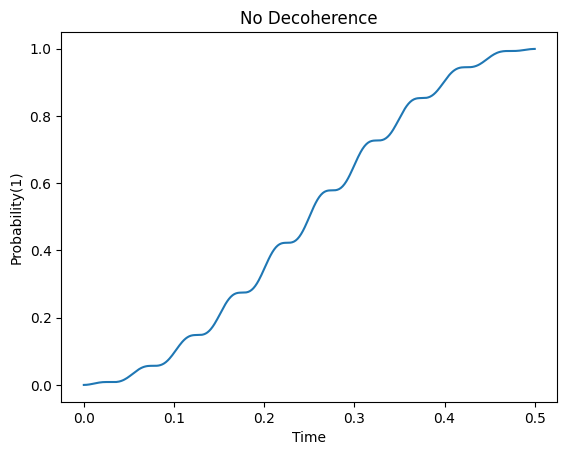

In [21]:
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                rho0,
                                observables=[operators.number(0)],
                                collapse_operators=[],
                                store_intermediate_results=True,
                                integrator=ScipyZvodeIntegrator())

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
ideal_results = [
    get_result(0, evolution_result)]



plt.figure()
plt.plot(steps, ideal_results[0])
plt.ylabel("Probability(1)")
plt.xlabel("Time")
plt.title("No Decoherence")

Now, things can get a bit more interesting when decoherence is factored in.  In this case, a so called collapse operator is added to the dynamical simulation to model the decay of energy into the environment as the system evolves. In this case the simple collapse operator `np.sqrt(gamma_sm) * spin.minus(0)` is added.  `gamma_sm` is set to 1, but would in practice be determined by some experimental quantity.  Now, by running this simulation, you will be able to simulate amplitude damping and see what the probability of the $\ket{1}$ state remains after the pulse. 

Text(0.5, 1.0, 'Decoherence')

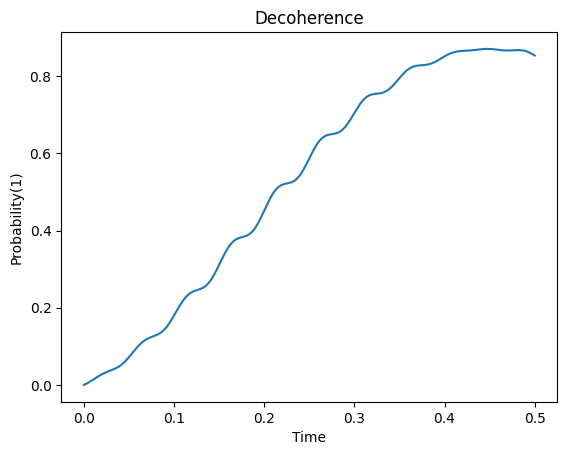

In [22]:
gamma_sm = 1.0
evolution_result_decay = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[operators.number(0)],
    collapse_operators=[
        np.sqrt(gamma_sm) * spin.minus(0),
    ],
    store_intermediate_results=True,
    integrator=ScipyZvodeIntegrator())

decoherence_results = [
    get_result(0, evolution_result_decay)
]

plt.figure()
plt.plot(steps, decoherence_results[0])
plt.ylabel("Probability(1)")
plt.xlabel("Time")
plt.title("Decoherence")

The pulse now has a peak of around .85, meaning $p=.15$ is a reasonable choice to parameterize an amplitude damping channel.

In [23]:
cudaq.set_target('density-matrix-cpu')
cudaq.set_random_seed(13)
noise = cudaq.NoiseModel()
 
amplitude_damping = cudaq.AmplitudeDampingChannel(0.15) # this value is from the dynamics simulation
noise.add_channel('x', [0], amplitude_damping)

kernel = cudaq.make_kernel()
qubit = kernel.qalloc()
kernel.x(qubit)
kernel.mz(qubit)
counts = cudaq.sample(kernel, noise_model=noise)
prob_1 = counts.probability("1")
print("Probability of |1> from the gate-level simulation with noise:", prob_1)

cudaq.reset_target()

Probability of |1> from the gate-level simulation with noise: 0.852


This is a very simple example, and in practice it is much harder to derive noise models from dynamical simulations.  Nevertheless, they are powerful tools for understanding noise.  You can also tweak other aspects of the simulation for more complex situations.  For example, try the following and see how they might change the amplitude damping parameterization.

1. change `omega_drive = 0.95 * omega_z` to be close to but not the same as the resonance frequency.
2. Add 0.1 to `t_final = np.pi / omega_x` to test what would happen if a gate pulse is applied for too long.

In [ ]:
# TO DO

## Summary ##

Noise is the greatest challenge facing quantum computers.  Accurate simulations can help us understand both the sources and impacts of noise to guide development of better hardware, algorithms, and QEC codes.   You now know how to utilize CUDA-Q for noise modeling as well as a number of situations where noise modeling is useful.  Scaling up any of these examples makes simulation much more challenging and requires the power of CUDA-Q and AI supercomputing to usher in new advancements to the field.